<a href="https://colab.research.google.com/github/ldaniel-hm/eml_approximate/blob/main/SolucionDeepSARSA_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Pesos y Generar Animación GIF para CartPole

En este script realizamos lo siguiente:

1. **Definir la arquitectura de la red neuronal (QNetwork):**
   - Esta red aproxima la función de acción-valor \( Q(s,a) \).
   - Para el entorno **CartPole-v1**, el estado tiene 4 dimensiones y existen 2 acciones posibles.

2. **Definir una función greedy para seleccionar acciones:**
   - Se escoge la acción que maximiza \( Q(s,a) \) (política determinista sin exploración).

3. **Ejecutar un episodio en el entorno usando la política greedy:**
   - Durante el episodio, se capturan fotogramas de cada paso para luego generar un GIF.

4. **Crear y mostrar un GIF en Google Colab:**
   - Se utiliza la biblioteca `imageio` para generar el GIF y `IPython.display.HTML` para visualizarlo.

5. **Cargar los pesos guardados:**
   - Se utiliza `torch.load` para recuperar los pesos previamente guardados en el archivo `sarsa_qnetwork.pth`.

Este script sirve como referencia para comprender cada paso en la recuperación y evaluación visual del agente.

In [1]:
# Importamos las librerías necesarias
import gymnasium as gym  # Biblioteca para entornos de aprendizaje por refuerzo.
import torch  # PyTorch: manejo de tensores y redes neuronales.
import torch.nn as nn  # Módulo para definir modelos de redes neuronales.
import torch.nn.functional as F  # Funciones de activación y utilidades de PyTorch.
import imageio  # Para crear el GIF a partir de los fotogramas.
import base64  # Para convertir el GIF a Base64 y visualizarlo en Colab.
from IPython.display import HTML  # Para mostrar HTML en Google Colab.

## 1. Definición de la Arquitectura de la Red Neuronal

La clase **QNetwork** define la red neuronal que aproxima la función $ Q(s,a) $.
Su estructura es la siguiente:

- **Entrada:** Estado del entorno (dimensión 4 para CartPole).
- **Capas ocultas:** Dos capas lineales con 64 neuronas cada una, utilizando la función de activación ReLU.
- **Salida:** Valores $ Q(s,a) $ para cada una de las 2 acciones posibles.

Matemáticamente, la red realiza:

\begin{align*}
h_1 &= \mathrm{ReLU}(W_1 s + b_1) \\
h_2 &= \mathrm{ReLU}(W_2 h_1 + b_2) \\
Q(s,a) &= W_3 h_2 + b_3
\end{align*}


donde $ s $ es el estado y $ Q(s,a) $ es el valor de la acción.

**¿Por qué se está usando esta red?** Porque alguna se tenía que usar. Puedes probar a usar una sola capa oculta con 130 neuronas, a probar con 3 capas ocultas, .... ¿qué se te ocurre a ti? Sería interesante estuidar si el número de capas y el número de neuronas en cada una influye en el resultado final.

In [2]:
class QNetwork(nn.Module):
    """
    Red neuronal para aproximar la función Q.

    Parámetros:
      - state_dim (int): Dimensión del estado (para CartPole: 4).
      - action_dim (int): Número de acciones posibles (para CartPole: 2).
      - hidden_dim (int): Número de neuronas en las capas ocultas (por defecto: 64).
    """

    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(QNetwork, self).__init__()
        # Primera capa: de estado a capa oculta de tamaño hidden_dim.
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        # Segunda capa oculta.
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Capa de salida: de hidden_dim a número de acciones.
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        """
        Propagación hacia adelante.

        Parámetro:
          - x (Tensor): Estado de entrada con forma [batch_size, state_dim].

        Retorna:
          - Tensor: Valores Q para cada acción, con forma [batch_size, action_dim].
        """
        # Aplicar la primera capa seguida de ReLU.
        x = F.relu(self.fc1(x))
        # Aplicar la segunda capa seguida de ReLU.
        x = F.relu(self.fc2(x))
        # Capa de salida sin activación, para obtener los valores Q.
        x = self.fc3(x)
        return x

## 2. Función Greedy para Seleccionar Acciones

La función **greedy_action** implementa la política determinista que, dada la salida de la red, selecciona
la acción con el mayor valor $ Q(s,a) $.

La elección se hace de la siguiente manera:

$$
a^{*} = \underset{a}{\arg\max}\, Q(s,a)
$$

Esto significa que, para un estado $ s $, se selecciona la acción $ a $ que maximiza el valor $Q$.

In [3]:
def greedy_action(q_network, state):
    """
    Selecciona la acción óptima (greedy) para un estado dado utilizando la red Q.

    Parámetros:
      - q_network (QNetwork): Red neuronal con los pesos cargados.
      - state: Estado actual del entorno (puede ser una lista o tensor).

    Retorna:
      - int: Acción que maximiza \( Q(s,a) \).
    """
    # Desactivamos el cálculo de gradientes (no es necesario en modo evaluación).
    with torch.no_grad():
        # Convertir el estado a tensor si no lo es y añadir dimensión de batch.
        if not isinstance(state, torch.Tensor):
            state = torch.FloatTensor(state).unsqueeze(0)
        # Calcular los valores Q para el estado.
        q_values = q_network(state)
        # Seleccionar la acción que maximiza Q(s,a).
        action = torch.argmax(q_values).item()
    return action

## 3. Ejecutar un Episodio con la Política Greedy y Capturar Fotogramas

La función **run_episode_greedy** ejecuta un episodio en el entorno usando la política greedy (sin exploración).
Durante el episodio:

1. Se reinicia el entorno para obtener el estado inicial.
2. En cada paso:
   - Se captura el fotograma actual usando `env.render()`.
   - Se selecciona la acción óptima con `greedy_action`.
   - Se ejecuta la acción en el entorno, actualizando el estado.
3. El episodio termina cuando se cumple la condición de `done` o `truncated`.

Los fotogramas se almacenan en una lista para ser usados en la creación del GIF.

In [4]:
def run_episode_greedy(env, q_network, max_steps=500):
    """
    Ejecuta un episodio usando la política greedy y captura los fotogramas.

    Parámetros:
      - env: Entorno Gymnasium configurado con render_mode='rgb_array'.
      - q_network: Red neuronal QNetwork con los pesos cargados.
      - max_steps (int): Número máximo de pasos a ejecutar en el episodio.

    Retorna:
      - list: Lista de fotogramas (imágenes) capturados durante el episodio.
    """
    frames = []  # Lista para almacenar cada fotograma.

    # Reiniciar el entorno y obtener el estado inicial.
    state, _ = env.reset()
    done = False  # Indicador de finalización del episodio.

    # Ejecutar el episodio hasta max_steps o hasta que el entorno indique que ha terminado.
    for _ in range(max_steps):
        # Capturar el fotograma actual del entorno.
        frame = env.render()
        frames.append(frame)

        # Seleccionar la acción óptima utilizando la función greedy.
        action = greedy_action(q_network, state)

        # Ejecutar la acción en el entorno y obtener el siguiente estado y otros datos.
        next_state, reward, done, truncated, info = env.step(action)
        state = next_state  # Actualizar el estado.

        # Si el episodio ha terminado o se ha truncado, capturar el fotograma final y salir.
        if done or truncated:
            frames.append(env.render())
            break

    return frames

## 4. Crear un GIF a partir de los Fotogramas

La función **frames_to_gif** utiliza la biblioteca **imageio** para escribir los fotogramas en un archivo GIF.
Cada fotograma es agregado secuencialmente y el resultado es un archivo animado que muestra el desempeño del agente.

La fórmula básica para escribir un GIF es:

$$
\text{GIF} = \{ \text{frame}_1, \text{frame}_2, \dots, \text{frame}_N \}
$$

In [5]:
def frames_to_gif(frames, filename="cartpole_sarsa.gif"):
    """
    Crea un archivo GIF a partir de una lista de fotogramas.

    Parámetros:
      - frames (list): Lista de fotogramas (imágenes) capturados del entorno.
      - filename (str): Nombre del archivo GIF resultante.

    Retorna:
      - str: Nombre del archivo GIF creado.
    """
    # Abrir un escritor de GIF con imageio.
    with imageio.get_writer(filename, mode='I') as writer:
        # Agregar cada fotograma al GIF.
        for frame in frames:
            writer.append_data(frame)
    return filename

## 5. Mostrar el GIF en Google Colab

La función **display_gif** convierte el archivo GIF a Base64 y lo incrusta en un objeto HTML para visualizarlo directamente en Colab.

Esto permite a los alumnos ver la animación sin necesidad de descargar el archivo.

In [6]:
def display_gif(gif_path):
    """
    Muestra un GIF en Google Colab.

    Parámetros:
      - gif_path (str): Ruta del archivo GIF.

    Retorna:
      - HTML: Objeto HTML que contiene el GIF incrustado.
    """
    # Abrir el archivo GIF en modo binario.
    with open(gif_path, 'rb') as f:
        video = f.read()
    # Convertir el contenido del GIF a una cadena Base64.
    b64 = base64.b64encode(video)
    # Retornar el objeto HTML que muestra el GIF.
    return HTML(f'<img src="data:image/gif;base64,{b64.decode()}" />')

## 6. Cargar la Red Neuronal y sus Pesos Guardados

Es fundamental que la arquitectura de la red definida a continuación **sea idéntica** a la utilizada en el entrenamiento.

En este ejemplo, se carga el archivo `sarsa_qnetwork.pth`, que contiene el state dict (diccionario de parámetros) de la red.

Se realiza lo siguiente:

1. Se indica la ubicación donde se encuentra los pesos para una red de tipo *QNetwork**
1. Se definen las dimensiones del estado y del espacio de acciones.
1. Se instancia la red **QNetwork**.
1. Se cargan los pesos con `torch.load`.
1. Se pone la red en modo evaluación usando `.eval()`, para desactivar comportamientos específicos de entrenamiento.

In [7]:
url = "https://github.com/ldaniel-hm/eml_approximate/raw/main/sarsa_qnetwork.pth" # Changed to raw file URL


# Usamos wget para descargar el archivo y lo guardamos con el nombre 'sarsa_qnetwork.pth'
!wget -O sarsa_qnetwork.pth $url

--2025-02-26 10:39:25--  https://github.com/ldaniel-hm/eml_approximate/raw/main/sarsa_qnetwork.pth
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ldaniel-hm/eml_approximate/main/sarsa_qnetwork.pth [following]
--2025-02-26 10:39:25--  https://raw.githubusercontent.com/ldaniel-hm/eml_approximate/main/sarsa_qnetwork.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21070 (21K) [application/octet-stream]
Saving to: ‘sarsa_qnetwork.pth’

sarsa_qnetwork.pth  100%[===================>]  20.58K  --.-KB/s    in 0.001s  

2025-02-26 10:39:25 (27.2 MB/s) - ‘sarsa_qnetwork.pth’ saved [21070/21070]



In [8]:
# Definir dimensiones del estado y número de acciones para CartPole.
state_dim = 4  # CartPole: 4 variables de estado.
action_dim = 2  # CartPole: 2 acciones posibles.

# Crear una instancia de la red QNetwork.
q_net_loaded = QNetwork(state_dim, action_dim)

# Cargar los pesos guardados en el archivo 'sarsa_qnetwork.pth'.
q_net_loaded.load_state_dict(torch.load("sarsa_qnetwork.pth"))

# Poner la red en modo evaluación para asegurar que se comporta correctamente en inferencia.
q_net_loaded.eval()

<ipython-input-8-1cccbb12f0e2>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_net_loaded.load_state_dict(torch.load("sarsa_qnetwork.pth"))


QNetwork(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

## 7. Generar la Animación GIF Usando la Política Greedy

Se crea un entorno de prueba para CartPole configurado con `render_mode='rgb_array'` para poder capturar imágenes.

Luego se ejecuta un episodio completo utilizando la función **run_episode_greedy**,
capturando cada fotograma y almacenándolo en una lista.

Finalmente, se crea el GIF a partir de esos fotogramas.

In [9]:
# Crear el entorno de CartPole con render_mode configurado para capturar imágenes.
env_demo = gym.make("CartPole-v1", render_mode='rgb_array')

# Ejecutar un episodio utilizando la política greedy y capturar los fotogramas.
frames = run_episode_greedy(env_demo, q_net_loaded, max_steps=500)

# Cerrar el entorno una vez terminado el episodio.
env_demo.close()

# Crear el GIF a partir de los fotogramas capturados.
gif_path = frames_to_gif(frames, filename="cartpole_sarsa.gif")
print("GIF guardado en:", gif_path)

GIF guardado en: cartpole_sarsa.gif


## 8. Visualizar la Animación en Google Colab

Finalmente, mostramos el GIF en el notebook usando la función **display_gif**.

Esto permitirá ver cómo se comporta el agente entrenado en el entorno.


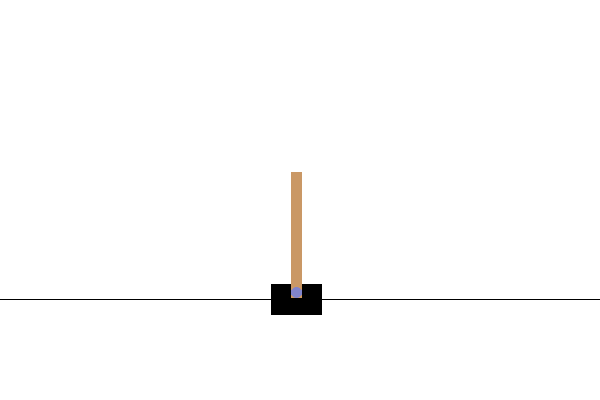

In [10]:
display_gif(gif_path)

La solución es aceptable, pero el plano es finito ¿Podría conseguir que se mantuviera lo máximo posibles en la mima zona sin llegar a los puntos extremos del plano? ¿Dependerá del número de entrenamientos? ¿Dependerá del tipo de red?

## ¡Fin del Script!

Este script incluye:

- La definición de la red neuronal.
- La política greedy para la selección de acciones.
- La ejecución de un episodio y captura de fotogramas.
- La creación y visualización de un GIF en Google Colab.

Los alumnos podrán utilizar este script como un punto de referencia completo para cargar un modelo entrenado y mostrarlo visualmente.

¡Espero que os resulte de gran ayuda!